It is always unpleasant when police stop you. Especially when you are late for something, have tons of things to do and etc. I don't like it either. Yet, I believe that rules are for everyone.
Long cut short, this time I will look at the data provided by Stanford University (https://openpolicing.stanford.edu/data/) about stop data in Connecticut covering 18 months starting from October 2013.
Features are self-explanatory.
I first analyze some aspects about stops in general, drivers, and reasons of stopping. Later, I build a prediction model trying to predict the possible outcome of a driver being pulled over. Let's start!

In [1]:
import pandas as pd                                #Working with csv, xls and other type of data files
import numpy as np                                 #Working with calculus
import matplotlib.pyplot as plt                    #Plotting library, similar to Matlab's
import seaborn as sns                              #Simplified visualization library built on Matplotlib

plt.rcParams['figure.figsize'] = (12,10)

import warnings                                    #Supress warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("CT_cleaned.csv")

In [3]:
data.head(3)

,id,state,stop_date,stop_time,location_raw,county_name,county_fips,fine_grained_location,police_department,driver_gender,...,violation_raw,violation,search_conducted,search_type_raw,search_type,contraband_found,stop_outcome,is_arrested,officer_id,stop_duration
0,CT-2013-00001,CT,2013-10-01,00:01,westport,Fairfield County,9001.0,"00000 N I 95 (WESTPORT, T158) X 18 LL",State Police,F,...,Speed Related,Speeding,False,NaN,NaN,False,Ticket,False,1000002754,1-15 min
1,CT-2013-00002,CT,2013-10-01,00:02,mansfield,Tolland County,9013.0,rte 195 storrs,State Police,M,...,Moving Violation,Moving violation,False,NaN,NaN,False,Verbal Warning,False,1000001903,1-15 min
2,CT-2013-00003,CT,2013-10-01,00:07,franklin,New London County,9011.0,Rt 32/whippoorwill,State Police,M,...,Speed Related,Speeding,False,NaN,NaN,False,Ticket,False,1000002711,1-15 min


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318669 entries, 0 to 318668
Data columns (total 24 columns):
id                       318669 non-null object
state                    318669 non-null object
stop_date                318669 non-null object
stop_time                318447 non-null object
location_raw             318669 non-null object
county_name              318627 non-null object
county_fips              318627 non-null float64
fine_grained_location    318021 non-null object
police_department        318669 non-null object
driver_gender            318669 non-null object
driver_age_raw           318669 non-null int64
driver_age               318395 non-null float64
driver_race_raw          318669 non-null object
driver_race              318669 non-null object
violation_raw            318669 non-null object
violation                318669 non-null object
search_conducted         318669 non-null bool
search_type_raw          4846 non-null object
search_type              484

Looks like we our data is pretty "dirty". Before doing any analysis, it is important to clean it

# Data cleansing

In [5]:
data.loc[0:5, ["stop_date", "stop_time"]]

,stop_date,stop_time
0,2013-10-01,00:01
1,2013-10-01,00:02
2,2013-10-01,00:07
3,2013-10-01,00:10
4,2013-10-01,00:10
5,2013-10-01,00:10


First of all, a proper Time data is needed. I will make it now

In [6]:
data["Time"] = pd.to_datetime(data["stop_date"] + " " + data["stop_time"])

In [7]:
data.columns

Index(['id', 'state', 'stop_date', 'stop_time', 'location_raw', 'county_name',
       'county_fips', 'fine_grained_location', 'police_department',
       'driver_gender', 'driver_age_raw', 'driver_age', 'driver_race_raw',
       'driver_race', 'violation_raw', 'violation', 'search_conducted',
       'search_type_raw', 'search_type', 'contraband_found', 'stop_outcome',
       'is_arrested', 'officer_id', 'stop_duration', 'Time'],
      dtype='object')

In [8]:
data.drop(['id','state','location_raw',
           'stop_date', 'stop_time',
           'fine_grained_location','driver_age',
           'driver_race_raw','violation_raw',
          'officer_id','police_department','county_fips','search_type_raw'], axis = 1, inplace = True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318669 entries, 0 to 318668
Data columns (total 12 columns):
county_name         318627 non-null object
driver_gender       318669 non-null object
driver_age_raw      318669 non-null int64
driver_race         318669 non-null object
violation           318669 non-null object
search_conducted    318669 non-null bool
search_type         4846 non-null object
contraband_found    318669 non-null bool
stop_outcome        313313 non-null object
is_arrested         313313 non-null object
stop_duration       318669 non-null object
Time                318447 non-null datetime64[ns]
dtypes: bool(2), datetime64[ns](1), int64(1), object(8)
memory usage: 24.9+ MB


It would be nice, having Time column at the front of the table

In [10]:
time = data['Time']
data.drop(labels=['Time'], axis=1,inplace = True)
data.insert(0, 'Time', time)

In [11]:
data.head(3)

,Time,county_name,driver_gender,driver_age_raw,driver_race,violation,search_conducted,search_type,contraband_found,stop_outcome,is_arrested,stop_duration
0,2013-10-01 00:01:00,Fairfield County,F,69,Black,Speeding,False,NaN,False,Ticket,False,1-15 min
1,2013-10-01 00:02:00,Tolland County,M,20,White,Moving violation,False,NaN,False,Verbal Warning,False,1-15 min
2,2013-10-01 00:07:00,New London County,M,34,Hispanic,Speeding,False,NaN,False,Ticket,False,1-15 min


Let's remove all NaT, or NaN values from our Time column before we proceed further


In [12]:
data = data[pd.notnull(data['Time'])]

In [13]:
print(data["Time"].min())
print(data["Time"].max())

2013-10-01 00:01:00
2015-03-31 12:59:00


We see that, our data is covering 18 months

Let's create some more additional columns

In [14]:
data["Month"] = data["Time"].apply(lambda x: x.strftime('%B'))             #'%B' stands for Month name
data["Weekday"] = data["Time"].apply(lambda x: x.strftime('%A'))           #'%A' stands for Weekday name     
data["Day of the Week"] = data["Time"].apply(lambda x: x.weekday())
data["Hour"] = data["Time"].apply(lambda x: x.hour)

In [15]:
data.search_type.unique()

array([nan, 'Consent', 'Other', 'Inventory'], dtype=object)

We can also delete search_type column, as it does not give us much information

In [16]:
data.drop("search_type", axis = 1, inplace = True)

# The Comicon effect 

After cleaning the data, I can start some exploratory analysis. Let's first take a look at timeline of stops.

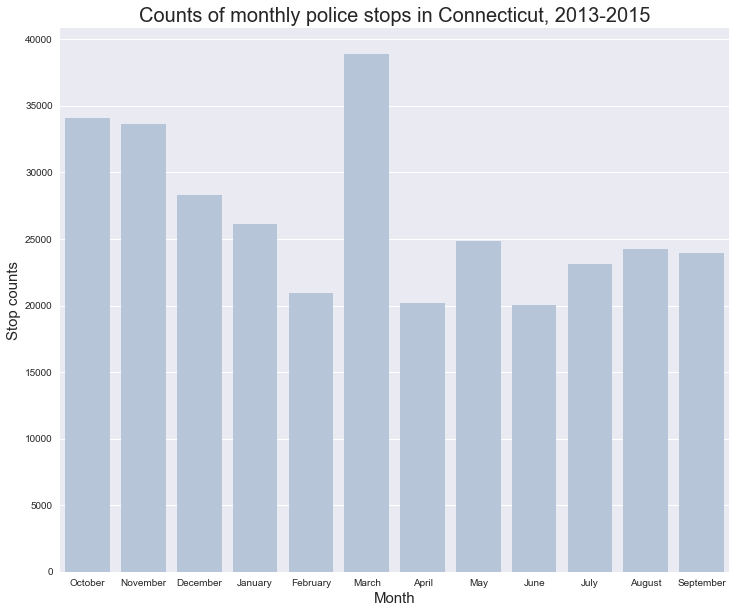

In [17]:
sns.countplot(data["Month"], color="lightsteelblue")
plt.title("Counts of monthly police stops in Connecticut, 2013-2015", fontsize = 20)
plt.xlabel("Month", fontsize = 15)
plt.ylabel("Stop counts", fontsize = 15)
plt.tick_params(labelsize = 10)
plt.show()

For some reason, before March, we observe a decrease, however, in March there is a sharp increase. Then, we see counts stabilize. What is the reason? 
Of course, Comicon! I found that, every year in March, there is a big Comicon event in Connecticut. In March 2014, it was 5th annual event which had more than 13k attendants also from neighbouring states.

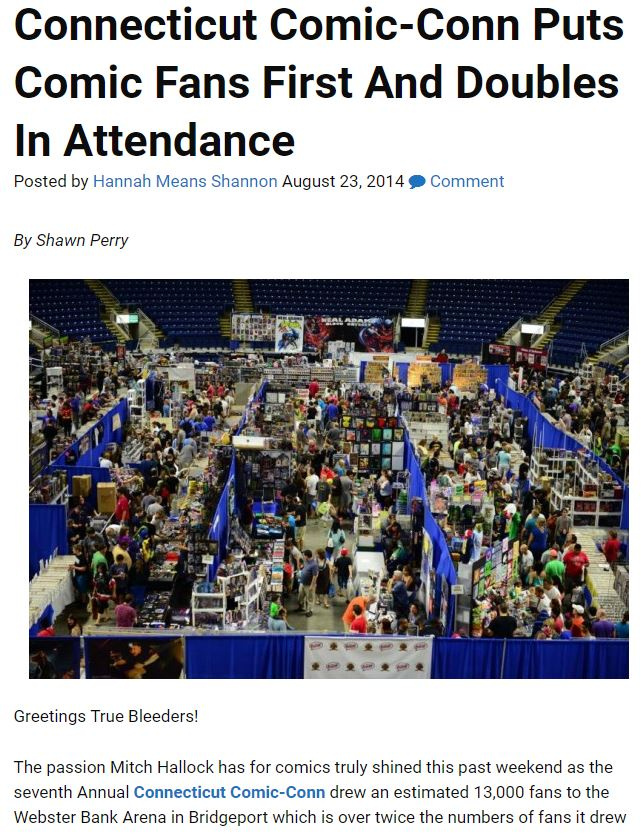

In [18]:
from IPython.display import Image
Image(filename='Comiconn 2014.JPG')

# Pulling over in the mornings

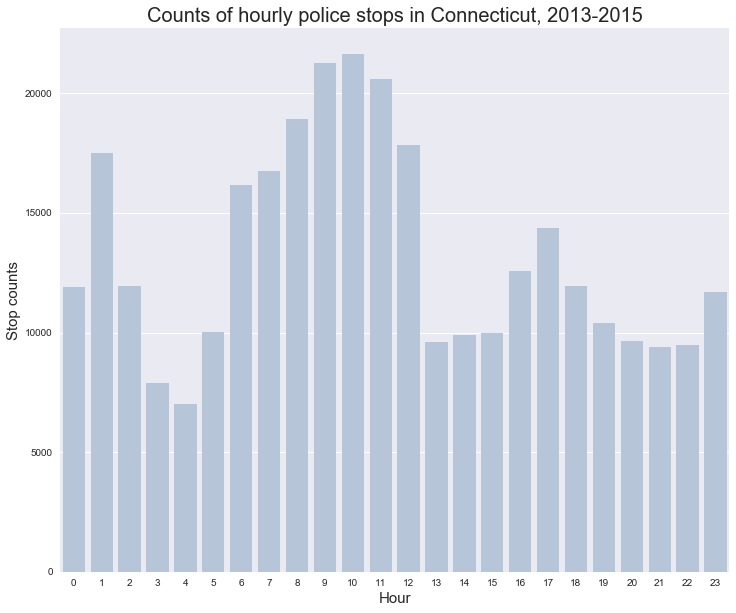

In [19]:
sns.countplot(data["Hour"], color="lightsteelblue")
plt.title("Counts of hourly police stops in Connecticut, 2013-2015", fontsize = 20)
plt.xlabel("Hour", fontsize = 15)
plt.ylabel("Stop counts", fontsize = 15)
plt.tick_params(labelsize = 10)

plt.show()

In the mornings people are stopped more. Late for work? Let's see whether or not Speeding is the main reason during those times.

In [20]:
#Top 3 stop reasons in the mornings
data[data["Hour"].apply(lambda x: x in range(6,12))]["violation"].value_counts().head(3)

Speeding               37875
Other                  32830
Registration/plates    14134
Name: violation, dtype: int64

In [21]:
#Top 3 stop reasons after mornings
data[data["Hour"].apply(lambda x: x not in range(6,12))]["violation"].value_counts().head(3)

Speeding               62911
Other                  54794
Registration/plates    23636
Name: violation, dtype: int64

Nothing interesting. Yet. What about percentage?

In [22]:
total_morning_stops = len(data[data["Hour"].apply(lambda x: x in range(6,12))])
total_other_stops = len(data[data["Hour"].apply(lambda x: x not in range(6,12))])

In [23]:
print("The percentage of speeding being the main reason during mornings is" +" " + str(37875/total_morning_stops*100))
print("The percentage of speeding being the main reason after mornings is" +" " + str(37875/total_other_stops*100))

The percentage of speeding being the main reason during mornings is 32.8305811988038
The percentage of speeding being the main reason after mornings is 18.65010192926995


Based on this result, we may clearly state that being late to work is the main reason being pulled over in the mornings

# Gender and race issues

What about drivers themselves? Gender, race and etc. Men vs women? Black vs asian? Let's have a look.

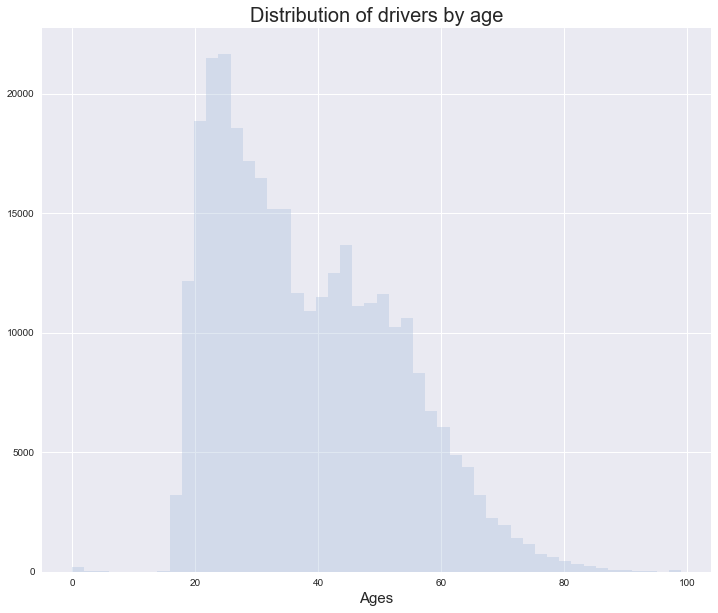

In [24]:
sns.distplot(data.driver_age_raw, color="lightsteelblue", kde= False)
plt.title("Distribution of drivers by age", fontsize = 20)
plt.xlabel("Ages", fontsize = 15)


plt.show()

We see that, mostly young people are stopped for traffic law violations. Interestingly, there were some cases where driver's age was above 80. I guess, once a rebel, always a rebel :)

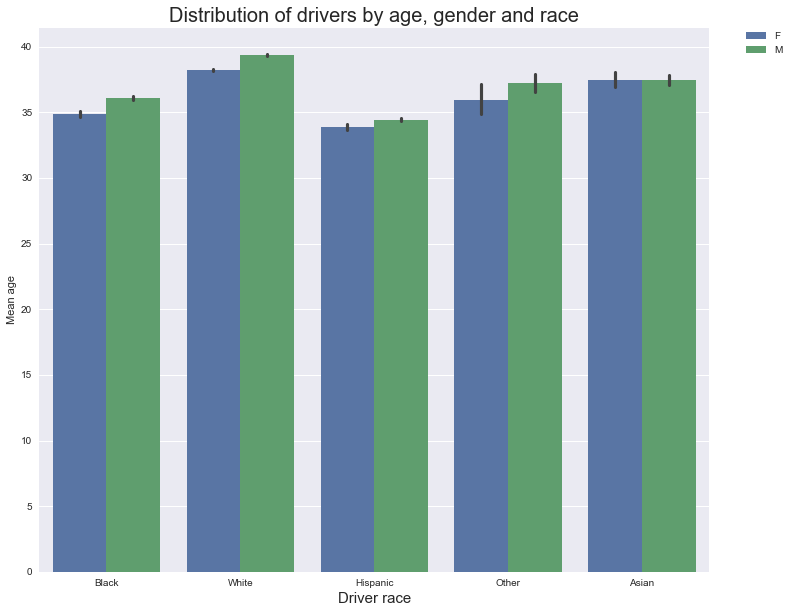

In [25]:
sns.barplot(x=data["driver_race"], y=data["driver_age_raw"], hue="driver_gender", data=data)
plt.title("Distribution of drivers by age, gender and race", fontsize = 20)
plt.xlabel("Driver race", fontsize = 15)
plt.ylabel("Mean age")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tick_params(labelsize = 10)
plt.show()

We observe that, males law breakers are generally older. Also, hispanic people violating traffic laws are in general, younger than the others. 

# Predicting the outcome via Trees

I already analyzed different aspects of the data. You may have a question in mind, what if I am pulled over? Which outcome(s) there could be? Now, let's try to build a model which can predict the outcome of you being pulled over.

In [26]:
#Let's look at our data, first
data.head()

,Time,county_name,driver_gender,driver_age_raw,driver_race,violation,search_conducted,contraband_found,stop_outcome,is_arrested,stop_duration,Month,Weekday,Day of the Week,Hour
0,2013-10-01 00:01:00,Fairfield County,F,69,Black,Speeding,False,False,Ticket,False,1-15 min,October,Tuesday,1,0
1,2013-10-01 00:02:00,Tolland County,M,20,White,Moving violation,False,False,Verbal Warning,False,1-15 min,October,Tuesday,1,0
2,2013-10-01 00:07:00,New London County,M,34,Hispanic,Speeding,False,False,Ticket,False,1-15 min,October,Tuesday,1,0
3,2013-10-01 00:10:00,Fairfield County,M,46,Black,Speeding,False,False,Written Warning,False,1-15 min,October,Tuesday,1,0
4,2013-10-01 00:10:00,Hartford County,M,30,White,Speeding,False,False,Ticket,False,1-15 min,October,Tuesday,1,0


In [27]:
#Which outcomes are possible?
data.stop_outcome.value_counts()

Ticket             218822
Verbal Warning      47714
Written Warning     27057
Summons             12196
Arrest               7304
Name: stop_outcome, dtype: int64

Most of the time, police just write a ticket for you. Speeding issues I presume.

In [28]:
top_violations = data.violation.value_counts().head(7).keys().tolist() #there are 5 outcomes, just in case I took first 7 :)

In [29]:
df = data[data["violation"].isin(top_violations)]

In [30]:
#Rename some columns
df = df.rename(columns = {"driver_gender":"gender","driver_age_raw" : "age", "driver_race":"race" })

In [31]:
#Dropping these columns. They either have lots of missin values, and/or is probably useles.
# I also drop stop_duration, as there is no accurate time
df.drop(["is_arrested", "Time", "county_name","stop_duration","Month","Day of the Week"], axis = 1, inplace= True)

In [32]:
#One last look at the data
df.head()

,gender,age,race,violation,search_conducted,contraband_found,stop_outcome,Weekday,Hour
0,F,69,Black,Speeding,False,False,Ticket,Tuesday,0
1,M,20,White,Moving violation,False,False,Verbal Warning,Tuesday,0
2,M,34,Hispanic,Speeding,False,False,Ticket,Tuesday,0
3,M,46,Black,Speeding,False,False,Written Warning,Tuesday,0
4,M,30,White,Speeding,False,False,Ticket,Tuesday,0


In [33]:
#Replacing categorical variables with dummies
df = pd.get_dummies(data= df, columns=["gender", "race", "violation", "search_conducted", "contraband_found", "Weekday"], drop_first= True)

In [34]:
#Checking null values
df.isnull().sum()

age                                 0
stop_outcome                     5088
Hour                                0
gender_M                            0
race_Black                          0
race_Hispanic                       0
race_Other                          0
race_White                          0
violation_Lights                    0
violation_Moving violation          0
violation_Other                     0
violation_Registration/plates       0
violation_Seat belt                 0
violation_Speeding                  0
search_conducted_True               0
contraband_found_True               0
Weekday_Monday                      0
Weekday_Saturday                    0
Weekday_Sunday                      0
Weekday_Thursday                    0
Weekday_Tuesday                     0
Weekday_Wednesday                   0
dtype: int64

In [35]:
#Force NA removal
df = df.dropna(axis= 0, how= 'any')

In [36]:
#Now data looks different and Machine learning friendly
df.head()

,age,stop_outcome,Hour,gender_M,race_Black,race_Hispanic,race_Other,race_White,violation_Lights,violation_Moving violation,...,violation_Seat belt,violation_Speeding,search_conducted_True,contraband_found_True,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
0,69,Ticket,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20,Verbal Warning,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,34,Ticket,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,46,Written Warning,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,30,Ticket,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [37]:
df.columns

Index(['age', 'stop_outcome', 'Hour', 'gender_M', 'race_Black',
       'race_Hispanic', 'race_Other', 'race_White', 'violation_Lights',
       'violation_Moving violation', 'violation_Other',
       'violation_Registration/plates', 'violation_Seat belt',
       'violation_Speeding', 'search_conducted_True', 'contraband_found_True',
       'Weekday_Monday', 'Weekday_Saturday', 'Weekday_Sunday',
       'Weekday_Thursday', 'Weekday_Tuesday', 'Weekday_Wednesday'],
      dtype='object')

In [38]:
from sklearn.ensemble import RandomForestClassifier   #Classifier itself
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score   #Metrics of the model. Accuracy and etc.
from sklearn.cross_validation import train_test_split  #For splitting our data into training and test sets


from sklearn.preprocessing import StandardScaler    #In case we need some scaling

In [39]:
clf = RandomForestClassifier()
sc = StandardScaler()

In [40]:
#X values are
X = df.drop("stop_outcome", axis = 1)

In [41]:
#y values are given a number per each class. From 0 to 4
y = pd.factorize(df["stop_outcome"])[0]
y

array([0, 1, 0, ..., 0, 0, 0])

In [42]:
#Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [43]:
#Model in action
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [44]:
#Predicting outcomes in test set
pred = clf.predict(X_test)

In [45]:
#How our results look like
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))
print("\n")
print("Accuracy score of our model is {}".format(accuracy_score(y_test, pred)))

             precision    recall  f1-score   support

          0       0.74      0.85      0.79     69085
          1       0.25      0.18      0.21     14484
          2       0.15      0.09      0.11      7973
          3       0.06      0.03      0.04      3114
          4       0.17      0.10      0.13      2178

avg / total       0.58      0.64      0.61     96834

[[58762  5810  2838   947   728]
 [10475  2562  1075   163   209]
 [ 5867  1260   696    79    71]
 [ 2611   222   102    84    95]
 [ 1569   238    81    67   223]]


Accuracy score of our model is 0.6436478922692442


I wished it to be better. Yet, 64 percent accuracy is still not bad. Now, let's use some more advanced technique

# Learning Deep 

Now, I will use Artificial Neural Network in order to solve this problem. Keras is an excellent high-level package which can work on Tensorflow, as well as Theano backends. After scaling our data (scaling is always welcomed in deep learning) I will proceed it through a network with 4 hidden layers, 10 nodes per each. In order to be more versatile, I use Kfold cross validation. It takes a while, until results are ready. So, running it, make sure you have some other things to do while waiting :)

In [46]:
from sklearn.preprocessing import StandardScaler                   # for normalization of our data
from keras.wrappers.scikit_learn import KerasClassifier            #package allowing keras to work with python
from sklearn.grid_search import GridSearchCV  #using Kfold and if needed, GridSearch object in analysis
from sklearn.utils import shuffle                                  # shuffling our own made dataset
from keras.models import Sequential                                # linear layer stacks model for keras
from keras.layers import Dense, Dropout
from sklearn.cross_validation import cross_val_score 

Using TensorFlow backend.


In [ ]:
#Scaling the data
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
y_train = sc.fit_transform(y_train)
y_test = sc.fit_transform(y_test)

In [48]:
def classifier_builder ():
    """
    Here, I will define our classifier builder object. I will use ANN with 4 hidden layers with 10 nodes each. My activation
    function will be relu(x, alpha=0.0, max_value=None), random weights of layers will be "uniformly" distirbuted,
    output node will have sigmoid activation function, because classification is binary. Input variables are 21, output
    variables are 5. For compiling of model I will use adam optimizer, binary cross entropy loss function.
    
    """
    classifier = Sequential()
    classifier.add(Dense(units = 10, activation='relu',kernel_initializer='uniform', input_dim = 21))
    #classifier.add(Dropout(p= 0.1))
    classifier.add(Dense(units = 10, activation='relu',kernel_initializer='uniform'))
    #classifier.add(Dropout(p= 0.1))
    classifier.add(Dense(units = 10, activation='relu',kernel_initializer='uniform'))
    #classifier.add(Dropout(p= 0.1))
    classifier.add(Dense(units = 10, activation='relu',kernel_initializer='uniform'))
    #classifier.add(Dropout(p= 0.1))
    classifier.add(Dense(units = 5, activation='softmax',kernel_initializer='uniform'))
    #classifier.add(Dropout(p= 0.1))
    classifier.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    return classifier

In [49]:
#Now we should create classifier object using our internal classifier object in the function above
#I will use 10 fold cross validation to increase my model's versatility and accuracy
classifier = KerasClassifier(build_fn= classifier_builder,
                             batch_size = 10,
                             nb_epoch = 100)
accuracies = cross_val_score(estimator=classifier, 
                             X = X_train,
                             y = y_train,
                             cv= 10)

Epoch 1/10
176940/176940 [==============================] - 19s - loss: 0.9012 - acc: 0.7136    
Epoch 2/10
176940/176940 [==============================] - 18s - loss: 0.8874 - acc: 0.7207    
Epoch 3/10
176940/176940 [==============================] - 18s - loss: 0.8713 - acc: 0.7218    
Epoch 4/10
176940/176940 [==============================] - 18s - loss: 0.8617 - acc: 0.7220    
Epoch 5/10
176940/176940 [==============================] - 18s - loss: 0.8599 - acc: 0.7222    
Epoch 6/10
176940/176940 [==============================] - 17s - loss: 0.8583 - acc: 0.7222    
Epoch 7/10
176940/176940 [==============================] - 17s - loss: 0.8559 - acc: 0.7233    
Epoch 8/10
176940/176940 [==============================] - 17s - loss: 0.8551 - acc: 0.7237    
Epoch 9/10
176940/176940 [==============================] - 17s - loss: 0.8543 - acc: 0.7238    
Epoch 10/10
176940/176940 [==============================] - 20s - loss: 0.9027 - acc: 0.7130    
Epoch 2/10
176940/176940 [===

176940/176940 [==============================] - 18s - loss: 0.8586 - acc: 0.7218    
Epoch 10/10
176940/176940 [==============================] - 18s - loss: 0.9025 - acc: 0.7143    
Epoch 2/10
176940/176940 [==============================] - 18s - loss: 0.8910 - acc: 0.7199    
Epoch 3/10
176940/176940 [==============================] - 18s - loss: 0.8880 - acc: 0.7205    
Epoch 4/10
176940/176940 [==============================] - 18s - loss: 0.8848 - acc: 0.7205    
Epoch 5/10
176940/176940 [==============================] - 18s - loss: 0.8683 - acc: 0.7205    
Epoch 6/10
176940/176940 [==============================] - 18s - loss: 0.8655 - acc: 0.7205    
Epoch 7/10
176940/176940 [==============================] - 18s - loss: 0.8649 - acc: 0.7205    
Epoch 8/10
176940/176940 [==============================] - 18s - loss: 0.8641 - acc: 0.7205    
Epoch 9/10
176940/176940 [==============================] - 18s - loss: 0.8637 - acc: 0.7206    
Epoch 10/10
176940/176940 [=============

In [50]:
print("Model's mean accuracy is {}".format(accuracies.mean()))

Model's mean accuracy is 0.7215869794712456


Better than Random Forest. After some parameter tuning using GridSearch, I got 0.78311 accuracy.
That would be all for now. Always try to drive safely!